# **Wikipedia spanish language model**

In [1]:
!git clone https://github.com/fastai/fastai2.git

Cloning into 'fastai2'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 8576 (delta 27), reused 16 (delta 5), pack-reused 8521
Receiving objects: 100% (8576/8576), 493.94 MiB | 16.59 MiB/s, done.
Resolving deltas: 100% (6887/6887), done.


In [2]:
!pip install fastai2

     |████████████████████████████████| 194kB 9.5MB/s 


In [3]:
from google.colab import drive, files
import zipfile
import os
import re
from pathlib import Path
from fastai2.text.all import *
import dill as pickle

In [5]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


### Data preparation (Results in drive)

Connecting drive, train and test set organization, tokenization, numericalization and creation of LMDataLoader

In [ ]:
#to not show cell output-- too long
%%capture
!unzip -q "/content/drive/My Drive/Colab Notebooks/TLAC/wiki_art.zip"

In [ ]:
def set_organization(dset):
  
  path="/content/wiki_art/{}".format(dset)

  for filename in os.listdir(path):
    os.rename(os.path.join(path, filename), os.path.join(path, re.sub('[^A-Za-z0-9]+(?![^.]*$)', '',filename)))

  n_files = len(list(os.listdir(path)))
  !ls $path
  print("elements_{}_set={} ".format(dset,n_files))


In [ ]:
%%capture
set_organization("train")

In [ ]:
%%capture
set_organization("test")

In [ ]:
path = Path('/content/wiki_art')
path.ls()

(#2) [Path('/content/wiki_art/test'),Path('/content/wiki_art/train')]

In [ ]:
texts = get_files(path, extensions=['.txt'], folders=['train', 'test'])

In [ ]:
def read_file(f): return L(f.read().split(' '))

In [ ]:
splits = RandomSplitter(valid_pct=0.1)(texts)
tfms = [Tokenizer.from_folder(path), Numericalize()]
dsets = Datasets(texts, [tfms], splits=splits, dl_type=LMDataLoader)

In [ ]:
pickle.dump(dsets, open(f'/content/dsets.pkl','wb'))

In [ ]:
!zip -r "/content/wiki_art_tok.zip" "/content/wiki_art_tok/"

In [ ]:
!mv "/content/dsets.pkl" "/content/drive/My Drive/Colab Notebooks/TLAC"

In [ ]:
!mv "/content/wiki_art_tok.zip" "/content/drive/My Drive/Colab Notebooks/TLAC"

##Model



In [9]:
!unzip -q "/content/drive/My Drive/Colab Notebooks/TLAC/wiki_art_tok.zip"

In [10]:
%%capture
!unzip /content/wiki_art_tok.zip

In [11]:
!mv "/content/content/wiki_art_tok" "/content/"

In [12]:
dsets = pickle.load(open(f'/content/drive/My Drive/Colab Notebooks/TLAC/dsets.pkl','rb'))

In [13]:
bs,sl=32,80
dbunch_lm = dsets.dataloaders(bs=bs, seq_len=sl, val_bs=bs)

In [ ]:
dbunch_lm.show_batch()

In [14]:
opt_func = partial(Adam, wd=0.1)
learn = language_model_learner(dbunch_lm, AWD_LSTM, opt_func=opt_func, metrics=accuracy)
learn = learn.to_fp16(clip=0.1)

###Training (Results in drive)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0691830962896347)

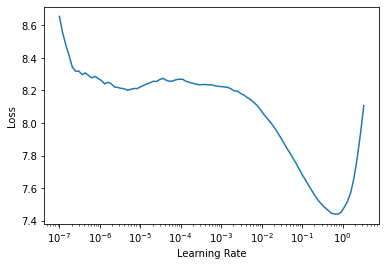

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 7e-2, moms=[0.8,0.7,0.8])

In [ ]:
learn.save('wm1')

In [ ]:
!zip -r /content/models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/wm1.pth (deflated 23%)


In [ ]:
files.download("/content/models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Fine tuning

In [6]:
%%capture
!unzip -q "/content/drive/My Drive/Colab Notebooks/TLAC/models.zip"

In [7]:
!mv "/content/content/models" "/content/"

In [16]:
learn.load('wm1')

In [17]:
learn.validate()

(#2) [4.0456390380859375,0.300513356924057]